# <small> <i>Task 8.</small> </i> 

* Divide a picture into roughly equal blocks of columns. Each process takes its own block. The number of columns $N$ is not equal to the number of processes $n_p$, i.e., $N \ne n_p$ in general.
* Create $N$ new pictures by cyclically shifting the columns of pixels. E.g., for $N = 3 $: $[c_0, c_1, c_2] \rightarrow [c_2, c_0, c_1] \rightarrow [c_1, c_2, c_0]$



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


**Google Drive**


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

image = np.array(Image.open('/content/gdrive/MyDrive/High Perfomance Python/Dream.jpg'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Local files**

In [ ]:
image = np.array(Image.open('Dream.jpg'))

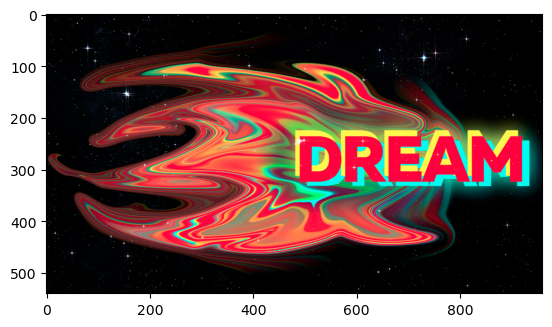

In [ ]:
plt.style.use('default')
plt.imshow(image)

In [ ]:
image.shape

(540, 960, 3)

In [ ]:
def roll(image, shift = 1):
    return np.roll(image, shift = (shift,shift,shift), axis=1)

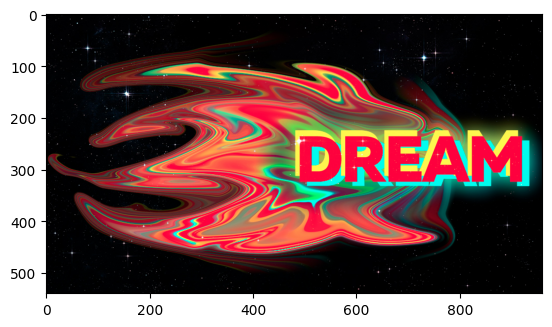

In [ ]:
plt.imshow(roll(image,(960)))

In [ ]:
%%writefile shifted_pic.py

from PIL import Image
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc

import tracemalloc # for memory tracing

def roll(image, shift = 1):
    return np.roll(image, shift = (shift,shift,shift), axis=0)

def roll_parallel(image, rank , n_proc, step):
    
    width_for_proc = image.shape[1] // n_proc
    last_part_width = image.shape[1] % n_proc

    if rank == n_proc -1:
        start = rank * width_for_proc
        end = (rank+1) * width_for_proc + last_part_width
        #pixels_width_proc = np.arange(rank*width_for_proc, (rank+1)*width_for_proc + last_part_width)
    else:
        start = rank * width_for_proc
        end = (rank+1) * width_for_proc
        #pixels_width_proc = np.arange(rank*width_for_proc, (rank+1)*width_for_proc)
    
    image_part = image[:, start:end ,:]
    image_part = roll(image_part, step)

    return image_part

tracemalloc.start()

path= 'Dream.jpg'

comm = MPI.COMM_WORLD
n_proc = comm.Get_size()
rank = comm.Get_rank()

fig = plt.figure()
image = np.array(Image.open(path))

if rank == 0:
    images = []

data = np.empty_like(image)
times = []
step = 2

for i in range(1, image.shape[0], step):
    
    start = MPI.Wtime()

    data = roll_parallel(image, rank, n_proc, i)
    data = comm.gather(data, root = 0)

    end = MPI.Wtime()

    times.append(end-start)

    if rank == 0:
        img = np.concatenate((data), axis = 1)
        im = plt.imshow(img, animated = True)

        images.append([im])

        # print('Mean time: ', np.mean(times)*1000, ' [sec]')
        # print('current_consumption: ', current,' ')
        # print()

if rank == 0:
    print('Mean time: ', np.mean(times)*1000, ' [sec]')

    current, peak = tracemalloc.get_traced_memory()
    print('current_consumption: ', current,' ')
    print('peak_consumption: ' ,peak)
    tracemalloc.stop()


    ani = animation.ArtistAnimation(fig, images, interval=10, blit=True, repeat_delay=1000)  
    ani.save('shifted_img.gif', writer='pillow', fps=500)
    #ani.save('shifted_img.mp4', writer='pillow', fps=20)


Overwriting shifted_pic.py


In [ ]:
!mpiexec -n 5 python shifted_pic.py

Mean time:  1.817848519055621  [sec]
current_consumption:  430901827  
peak_consumption:  434010481


In [ ]:
import subprocess

times = []
memory = []
peaks = []

for i in range(1,12,1):
    a = subprocess.run(["mpiexec","-n", str(i), "python", "shifted_pic.py" ],
                       universal_newlines = True,
                       stdout = subprocess.PIPE,
                       stderr = subprocess.PIPE)
    res = list(a.stdout.strip().split(' '))
    
    times.append(float(res[3]))
    memory.append(float(res[7]))
    peaks.append(float(res[11]))


In [ ]:
res

['Mean',
 'time:',
 '',
 '1.848126296385157',
 '',
 '[sec]\ncurrent_consumption:',
 '',
 '430926772',
 '',
 '\npeak_consumption:',
 '',
 '434035592']

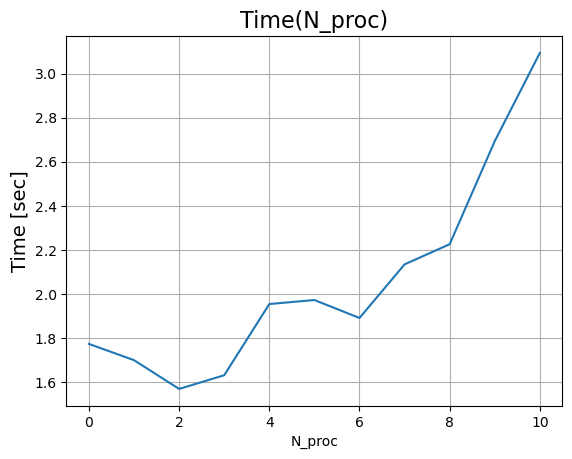

In [ ]:
plt.style.use('default')
plt.plot(np.array(times))

plt.title('Time(N_proc)', fontsize = 16)
plt.xlabel('N_proc')
plt.ylabel('Time [sec]',fontsize = 14)
plt.grid()
plt.show()

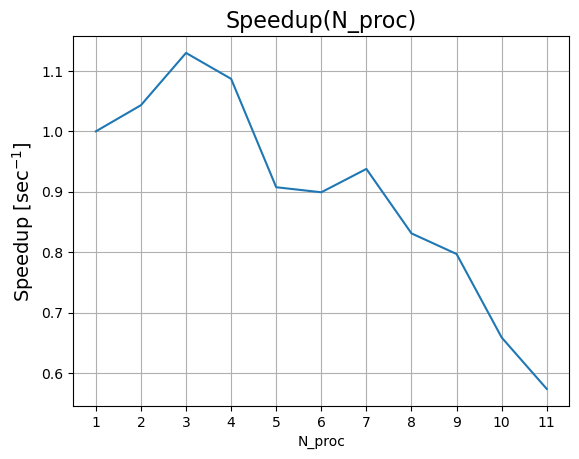

In [ ]:
plt.style.use('default')
plt.plot(np.arange(1,12), times[0]/np.array(times))

plt.title('Speedup(N_proc)', fontsize = 16)
plt.xlabel('N_proc')
plt.xticks(np.arange(1,12))

plt.ylabel('Speedup [sec$^{-1}$]',fontsize = 14)
plt.grid()
plt.show()

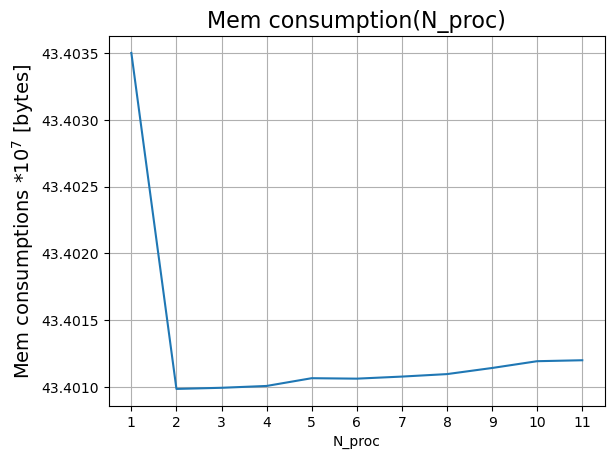

In [ ]:
plt.style.use('default')
plt.plot(np.arange(1,12), (np.array(peaks)/10**7))

plt.title('Mem consumption(N_proc)', fontsize = 16)
plt.xlabel('N_proc')
plt.xticks(np.arange(1,12))
plt.ticklabel_format(useOffset=False)

plt.ylabel('Mem consumptions $*10^7$ [bytes]',fontsize = 14)
plt.grid()
plt.show()

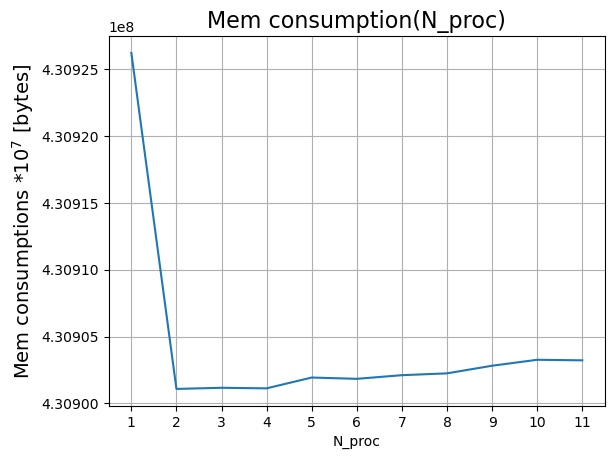

In [ ]:
plt.style.use('default')
plt.plot(np.arange(1,12), (np.array(memory)))

plt.title('Mem consumption(N_proc)', fontsize = 16)
plt.xlabel('N_proc')
plt.xticks(np.arange(1,12))
plt.ticklabel_format(useOffset=False)

plt.ylabel('Mem consumptions $*10^7$ [bytes]',fontsize = 14)
plt.grid()
plt.show()

In [ ]:
memory[0]

430926213.0